In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Exploratory Data Analysis

In [2]:
# do this to make Pandas show all the columns of a DataFrame, otherwise it just shows a summary
pd.set_option('display.max_columns', None) 

In [3]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

train_id = df_train['Id']
test_id = df_test['Id']

train_idhogar = df_train['idhogar']
test_idhogar = df_train['idhogar']

df_train.drop(columns=['Id'], inplace=True)
df_test.drop(columns=['Id'], inplace=True)

print("Shape of train data: ", df_train.shape)
print("Shape of test data: ", df_test.shape)

ntrain = df_train.shape[0]
ntest = df_test.shape[0]

all_data = pd.concat((df_train, df_test)).reset_index(drop=True)

Shape of train data:  (9557, 142)
Shape of test data:  (23856, 141)


In [4]:
print("A glimpse at the columns of training data:")
df_train.head()

A glimpse at the columns of training data:


v2a1  hacdor  rooms  hacapo  v14a  refrig  v18q  v18q1  r4h1  r4h2  \
0  190000.0       0      3       0     1       1     0    NaN     0     1   
1  135000.0       0      4       0     1       1     1    1.0     0     1   
2       NaN       0      8       0     1       1     0    NaN     0     0   
3  180000.0       0      5       0     1       1     1    1.0     0     2   
4  180000.0       0      5       0     1       1     1    1.0     0     2   

   r4h3  r4m1  r4m2  r4m3  r4t1  r4t2  r4t3  tamhog  tamviv  escolari  \
0     1     0     0     0     0     1     1       1       1        10   
1     1     0     0     0     0     1     1       1       1        12   
2     0     0     1     1     0     1     1       1       1        11   
3     2     1     1     2     1     3     4       4       4         9   
4     2     1     1     2     1     3     4       4       4        11   

   rez_esc  hhsize  paredblolad  paredzocalo  paredpreb  pareddes  paredmad  \
0      NaN       1            1            0          0         0         0   
1      NaN       1            0            0          0         0         1   
2      NaN       1            0            0          0         0         1   
3      1.0       4            1            0          0         0         0   
4      NaN       4            1            0          0         0         0   

   paredzinc  paredfibras  paredother  pisomoscer  pisocemento  pisoother  \
0          0            0           0           1            0          0   
1          0            0           0           0            0          0   
2          0            0           0           1            0          0   
3          0            0           0           1            0          0   
4          0            0           0           1            0          0   

   pisonatur  pisonotiene  pisomadera  techozinc  techoentrepiso  techocane  \
0          0            0           0          0               1          0   
1          0            0           1          1               0          0   
2          0            0           0          1               0          0   
3          0            0           0          1               0          0   
4          0            0           0          1               0          0   

   techootro  cielorazo  abastaguadentro  abastaguafuera  abastaguano  public  \
0          0          1                1               0            0       1   
1          0          1                1               0            0       1   
2          0          1                1               0            0       1   
3          0          1                1               0            0       1   
4          0          1                1               0            0       1   

   planpri  noelec  coopele  sanitario1  sanitario2  sanitario3  sanitario5  \
0        0       0        0           0           1           0           0   
1        0       0        0           0           1           0           0   
2        0       0        0           0           1           0           0   
3        0       0        0           0           1           0           0   
4        0       0        0           0           1           0           0   

   sanitario6  energcocinar1  energcocinar2  energcocinar3  energcocinar4  \
0           0              0              0              1              0   
1           0              0              1              0              0   
2           0              0              1              0              0   
3           0              0              1              0              0   
4           0              0              1              0              0   

   elimbasu1  elimbasu2  elimbasu3  elimbasu4  elimbasu5  elimbasu6  epared1  \
0          1          0          0          0          0          0        0   
1          1          0          0          0          0          0        0   
2          1          0    

These are the core data fields as described in the [data description](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data):

* Id - a unique identifier for each row.
* Target - the target is an ordinal variable indicating groups of income levels. 
    1 = extreme poverty 
    2 = moderate poverty 
    3 = vulnerable households 
    4 = non vulnerable households
* idhogar - this is a unique identifier for each household. This can be used to create household-wide features, etc. All rows in a given household will have a matching value for this identifier.
* parentesco1 - indicates if this person is the head of the household.


In [5]:
print("The feature that we need to predict: ", set(df_train.columns) - set(df_test.columns))

The feature that we need to predict:  {'Target'}


Let's see a description of `Target`: 

In [6]:
df_train['Target'].describe()

count    9557.000000
mean        3.302292
std         1.009565
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         4.000000
Name: Target, dtype: float64

We need to make predictions on a household level whereas we have been given the data at an individual level. 

That is why during all our analysis we will focus only on those columns which have `parentesco1 == 1`. These are columns for the heads of households and each household has only one head. 

In [7]:
def barplot_with_anotate(feature_list, y_values, plotting_space=plt, annotate_vals=None):
    x_pos = np.arange(len(feature_list))
    plotting_space.bar(x_pos, y_values);
    plotting_space.xticks(x_pos, feature_list, rotation=270);
    if annotate_vals == None:
        annotate_vals = y_values
    for i in range(len(feature_list)):
        plotting_space.text(x=x_pos[i]-0.3, y=y_values[i]+1.0, s=annotate_vals[i]);

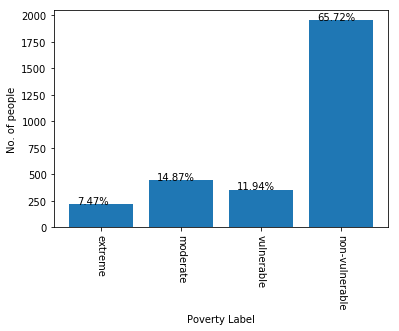

In [8]:
df_train_heads = df_train.loc[df_train['parentesco1'] == 1]
poverty_label_sizes = list(df_train_heads.groupby('Target').size())

barplot_with_anotate(['extreme', 'moderate', 'vulnerable', 'non-vulnerable'], poverty_label_sizes,
                     annotate_vals = [str(round((count/df_train_heads.shape[0])*100, 2))+'%' 
                                      for count in poverty_label_sizes]);
plt.rcParams["figure.figsize"] = [6, 6];
plt.xlabel('Poverty Label');
plt.ylabel('No. of people');

So, we can see that **_a majority (>65%) of the households fall within the `Non-vulnerable` category_**. This means that we are dealing with an imbalanced classification problem.

Now, let's try to understand what it means to live under such conditions.

## Home Life for various poverty groups:

In [9]:
def plot_dwelling_property(property_df):
    _, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(16, 16))

    target_idx = 0
    for row in range(2):
        for col in range(2):
            percentage_list = [round((count/poverty_label_sizes[target_idx])*100, 2)
                                 for count in list(property_df.iloc[target_idx, :])]
            x_pos = list(range(len(property_df.columns)))
            
            axarr[row, col].bar(x_pos, 
                                percentage_list, 
                                color='y')
            
            axarr[row, col].set_title('For individuals in Poverty group=' + str(target_idx+1))
            
            xtick_labels = list(property_df.columns)
            xtick_labels.insert(0, '') # insert a blank coz `set_xticklabels()` skips the 1st element ##why??
            axarr[row, col].set_xticklabels(xtick_labels, rotation=300)
            
            axarr[row, col].set_ylim(bottom=0, top=100)
            #axarr[row, col].set_xlim(left=0, right=len(property_df.columns))
            
            for i in range(len(property_df.columns)):
                axarr[row, col].annotate(xy=(x_pos[i]-0.3, percentage_list[i]+1.0), s=percentage_list[i]);
            
            axarr[0, 0].set_ylabel("Percentage of the total in this poverty group");
            axarr[1, 0].set_ylabel("Percentage of the total in this poverty group");
            axarr[1, 0].set_xlabel("Types");
            axarr[1, 1].set_xlabel("Types");

            axarr[row, col].autoscale(enable=True, axis='x')
            target_idx+=1

### Outside wall material of the house:

In [10]:
outside_wall_material_df = df_train_heads.groupby('Target').sum()[['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 
                                  'paredzinc', 'paredfibras', 'paredother']]
outside_wall_material_df

paredblolad  paredzocalo  paredpreb  pareddes  paredmad  paredzinc  \
Target                                                                       
1                84           24         58         6        44          4   
2               175           54        105        10        87          9   
3               182           30         84         4        54          1   
4              1353          123        298         5       154         16   

        paredfibras  paredother  
Target                           
1                 2           0  
2                 1           1  
3                 0           0  
4                 2           3

```
paredblolad, =1 if predominant material on the outside wall is block or brick
paredzocalo, "=1 if predominant material on the outside wall is socket (wood,  zinc or absbesto"
paredpreb, =1 if predominant material on the outside wall is prefabricated or cement
pareddes, =1 if predominant material on the outside wall is waste material
paredmad, =1 if predominant material on the outside wall is wood
paredzinc, =1 if predominant material on the outside wall is zink
paredfibras, =1 if predominant material on the outside wall is natural fibers
paredother, =1 if predominant material on the outside wall is other
```

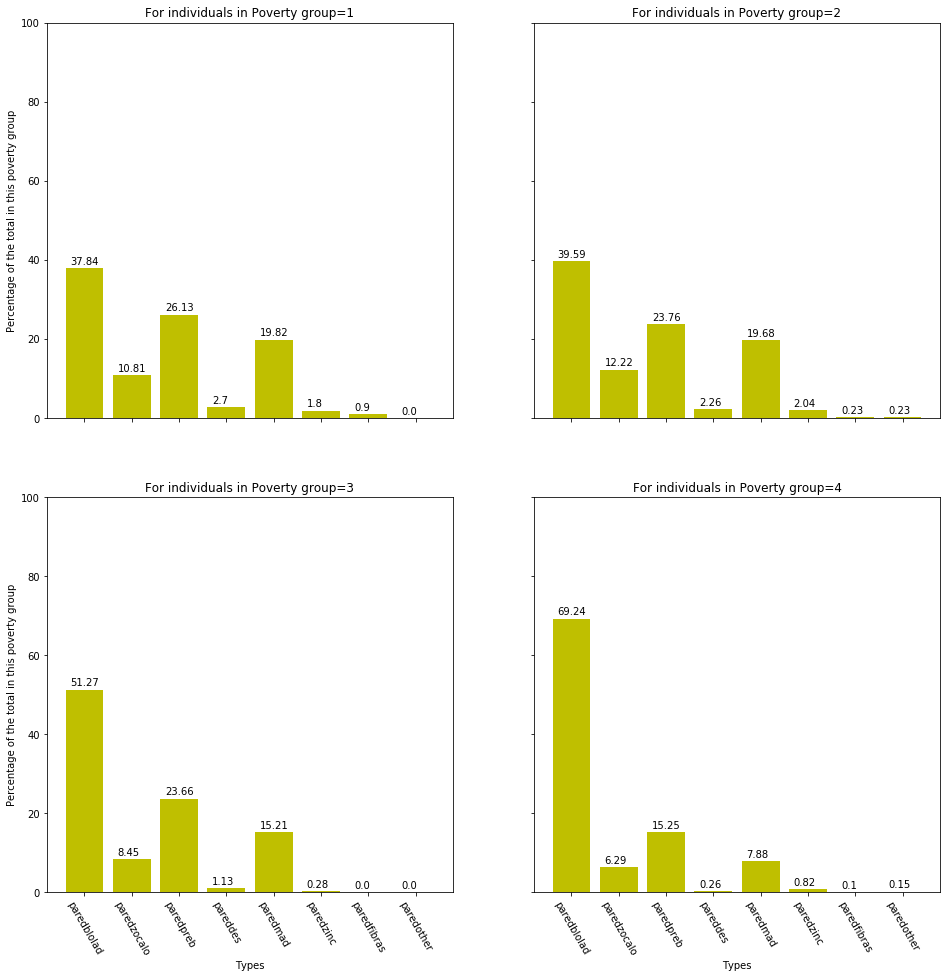

In [11]:
plot_dwelling_property(outside_wall_material_df)

* We see that a majority (69.24%) of the households under poverty group 4 (non-vulnerable) have brick wall on the outside. 
* As we go from there to group 1 (extreme), the percentage of houses having brick wall decreases. Cement wall and wood walls become increasingly more common.
* The top 3 most common types of wall material across all the groups are (in descending order of popularity) - 
  `brick` > `prefabricated or cement` > `wood`

### Floor material of the house:

In [12]:
floor_material_df = df_train_heads.groupby('Target').sum()[['pisomoscer', 'pisocemento', 'pisoother',
                                                      'pisonatur', 'pisonotiene', 'pisomadera']]
floor_material_df

pisomoscer  pisocemento  pisoother  pisonatur  pisonotiene  pisomadera
Target                                                                        
1              101           89          0          1            8          23
2              226          147          0          2           16          51
3              223           96          0          0            6          30
4             1551          301          2          0            8          92

```
pisomoscer, "=1 if predominant material on the floor is mosaic,  ceramic,  terrazo"
pisocemento, =1 if predominant material on the floor is cement
pisoother, =1 if predominant material on the floor is other
pisonatur, =1 if predominant material on the floor is  natural material
pisonotiene, =1 if no floor at the household
pisomadera, =1 if predominant material on the floor is wood
```

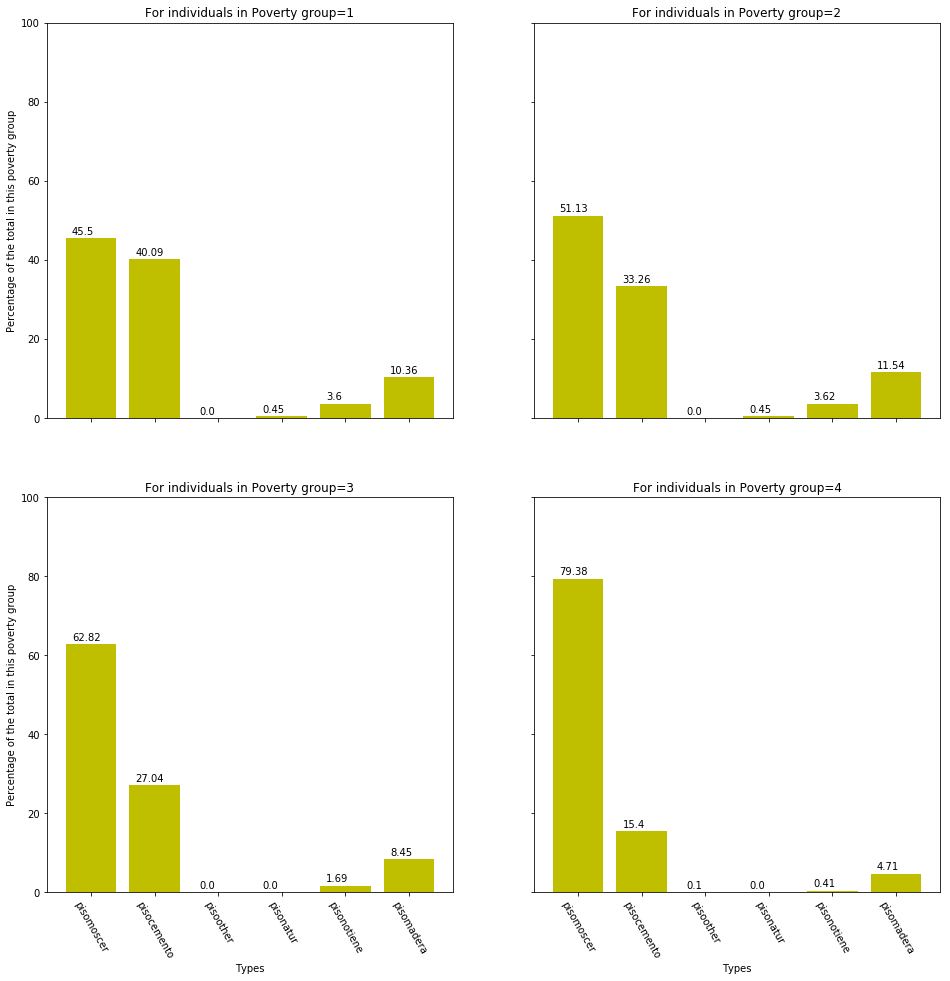

In [13]:
plot_dwelling_property(floor_material_df)

* We see that a majority of households belonging to poverty group 3 (vulnerable) and group 4 (non-vulnerable) have `mossaic, ceramic, tazzo` floors (62.82% and 79.38% respectively)
* This floor type becomes less common as we move across from group 4 to group 1 and other types (especially the cemented floors) become more common.
* The top 3 most common types of floors across all the groups are (in descending order of popularity) -   
  `mossaic, ceramic, tazzo` > `cemented` > `wooden`

### Toilet:

In [14]:
toilet_df = df_train_heads.groupby('Target').sum()[['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5',
                                              'sanitario6']]
toilet_df

sanitario1  sanitario2  sanitario3  sanitario5  sanitario6
Target                                                            
1                3          33         177           8           1
2                4          78         348          10           2
3                3          54         289           9           0
4                5         504        1429          12           4

```
sanitario1, =1 no toilet in the dwelling
sanitario2, =1 toilet connected to sewer or cesspool
sanitario3, =1 toilet connected to  septic tank
sanitario5, =1 toilet connected to black hole or letrine
sanitario6, =1 toilet connected to other system
```

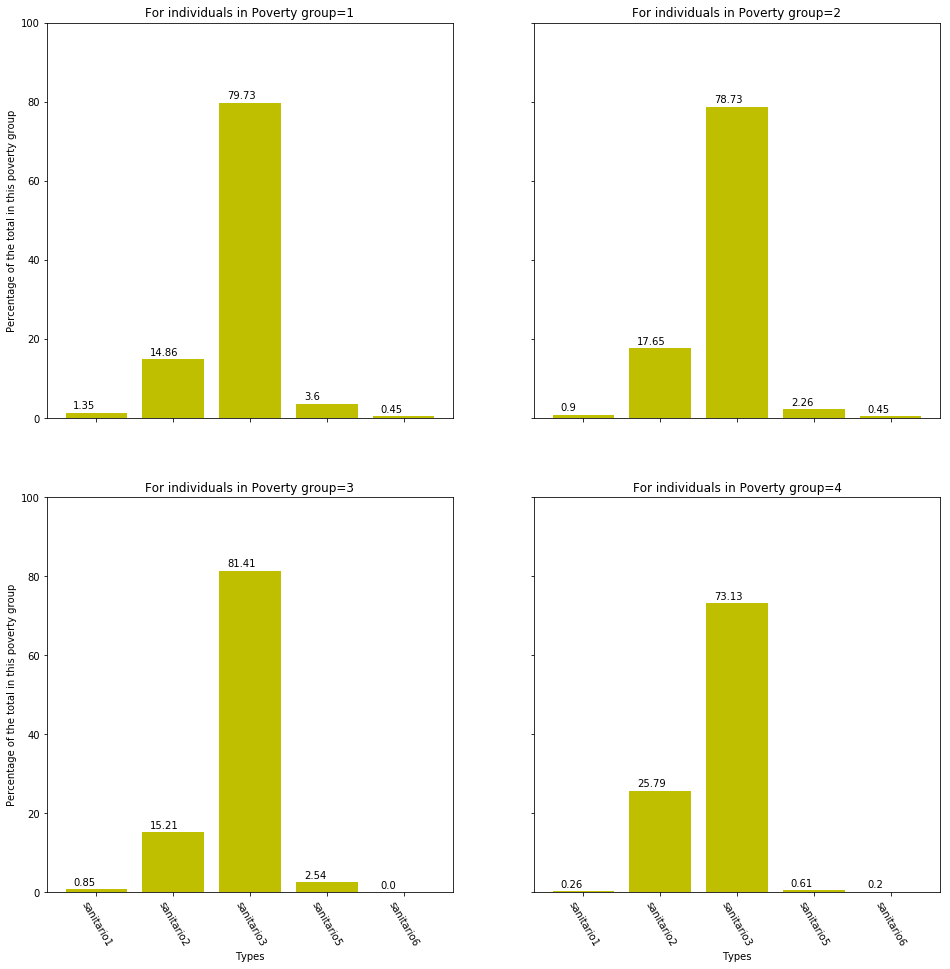

In [15]:
plot_dwelling_property(toilet_df)

* A large majority of the households have a toilet connected to a septic tank (73% - 81%).
* A toilet connected to sewer or cess pool becomes more common as we move to group 4. It is probably a better, more expensive type of installation. 

### Rubbish disposal:

In [16]:
rubbish_disposal_df = df_train_heads.groupby('Target').sum()[['elimbasu1', 'elimbasu2', 'elimbasu3',
                                                        'elimbasu4', 'elimbasu5', 'elimbasu6']]
rubbish_disposal_df

elimbasu1  elimbasu2  elimbasu3  elimbasu4  elimbasu5  elimbasu6
Target                                                                  
1             178          9         35          0          0          0
2             352         24         63          3          0          0
3             300         13         41          1          0          0
4            1800         44        106          0          0          4

```
elimbasu1, =1 if rubbish disposal mainly by tanker truck
elimbasu2, =1 if rubbish disposal mainly by botan hollow or buried
elimbasu3, =1 if rubbish disposal mainly by burning
elimbasu4, =1 if rubbish disposal mainly by throwing in an unoccupied space
elimbasu5, "=1 if rubbish disposal mainly by throwing in river,  creek or sea"
elimbasu6, =1 if rubbish disposal mainly other
```

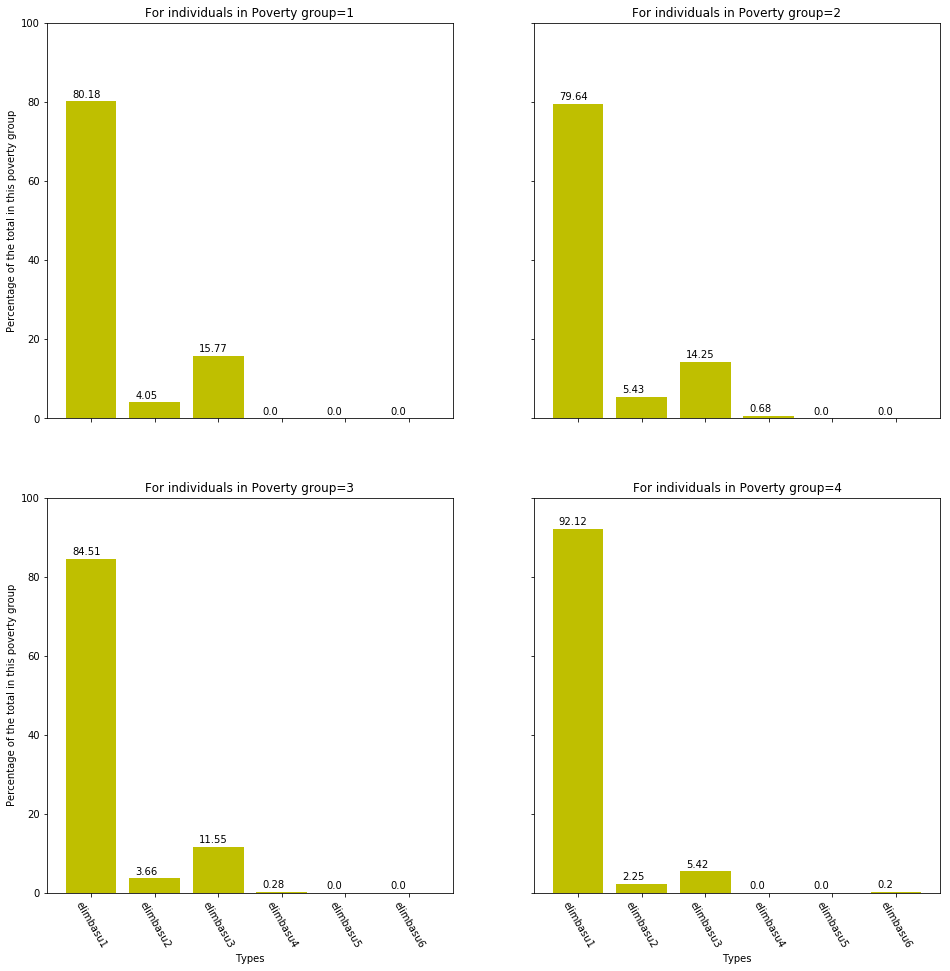

In [17]:
plot_dwelling_property(rubbish_disposal_df)

* A large majority of the households in all the poverty groups dispose their rubbish using tanker trucks.
* Rubbish disposal by burning is the 2nd most popular way and its popularity increases as we move from group 4 (non-vulnerable) to group 1 (extreme). This may be as a result of lack of environmental awareness or a lack of resources in the less fortunate hopes.

### Roof material of the house:

In [18]:
roof_material_df = df_train_heads.groupby('Target').sum()[['techozinc', 'techoentrepiso', 'techocane', 'techootro']]
roof_material_df

techozinc  techoentrepiso  techocane  techootro
Target                                                 
1             211               3          3          0
2             425               8          0          0
3             351               2          1          0
4            1887              51          5          7

```
techozinc, =1 if predominant material on the roof is metal foil or zink
techoentrepiso, "=1 if predominant material on the roof is fiber cement,  mezzanine "
techocane, =1 if predominant material on the roof is natural fibers
techootro, =1 if predominant material on the roof is other
```

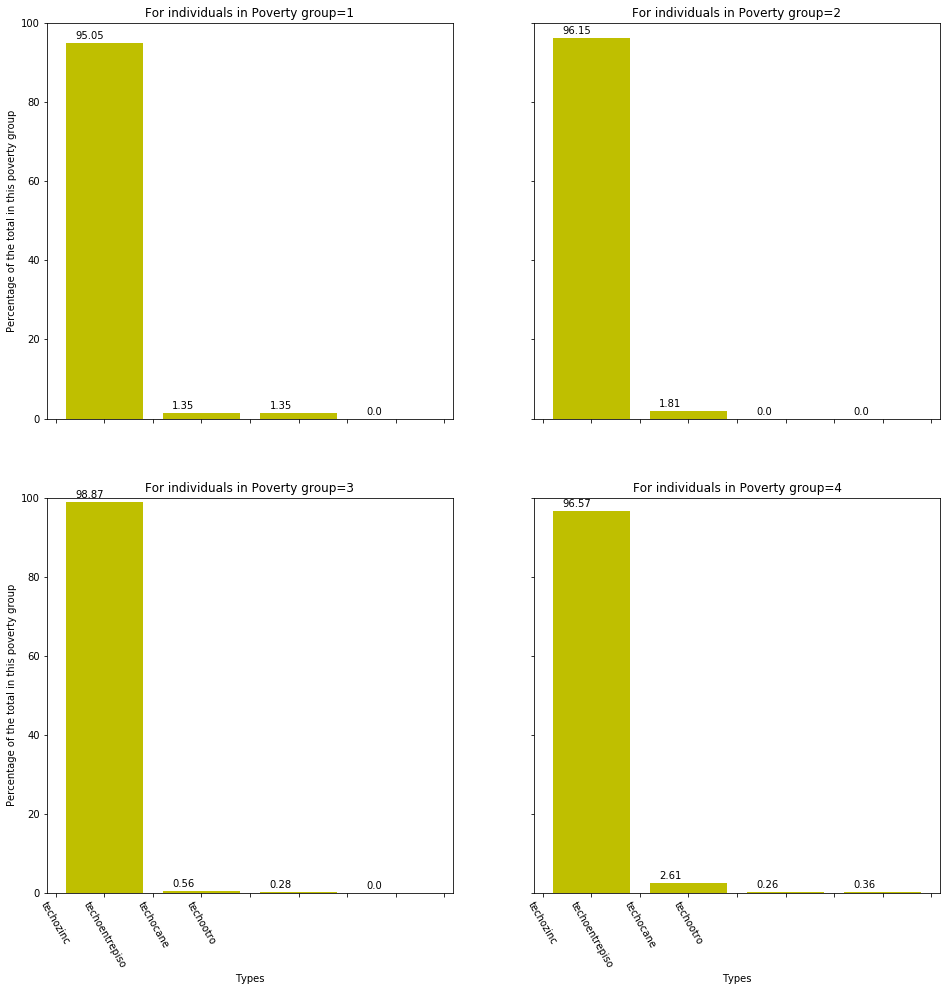

In [19]:
plot_dwelling_property(roof_material_df)

* This distrubution is pretty much the same throughout all the groups. A huge majority (> 95%) of the individuals live in homes with metal foil or zinc roof. 

**_We may conclude that these features are not representative of the poverty levels._**

### Water provision:

In [20]:
water_provision_df = df_train_heads.groupby('Target').sum()[['abastaguadentro', 'abastaguafuera', 'abastaguano']]
water_provision_df

abastaguadentro  abastaguafuera  abastaguano
Target                                              
1                   212               9            1
2                   416              20            6
3                   342              11            2
4                  1906              46            2

```
abastaguadentro, =1 if water provision inside the dwelling
abastaguafuera, =1 if water provision outside the dwelling
abastaguano, =1 if no water provision
```

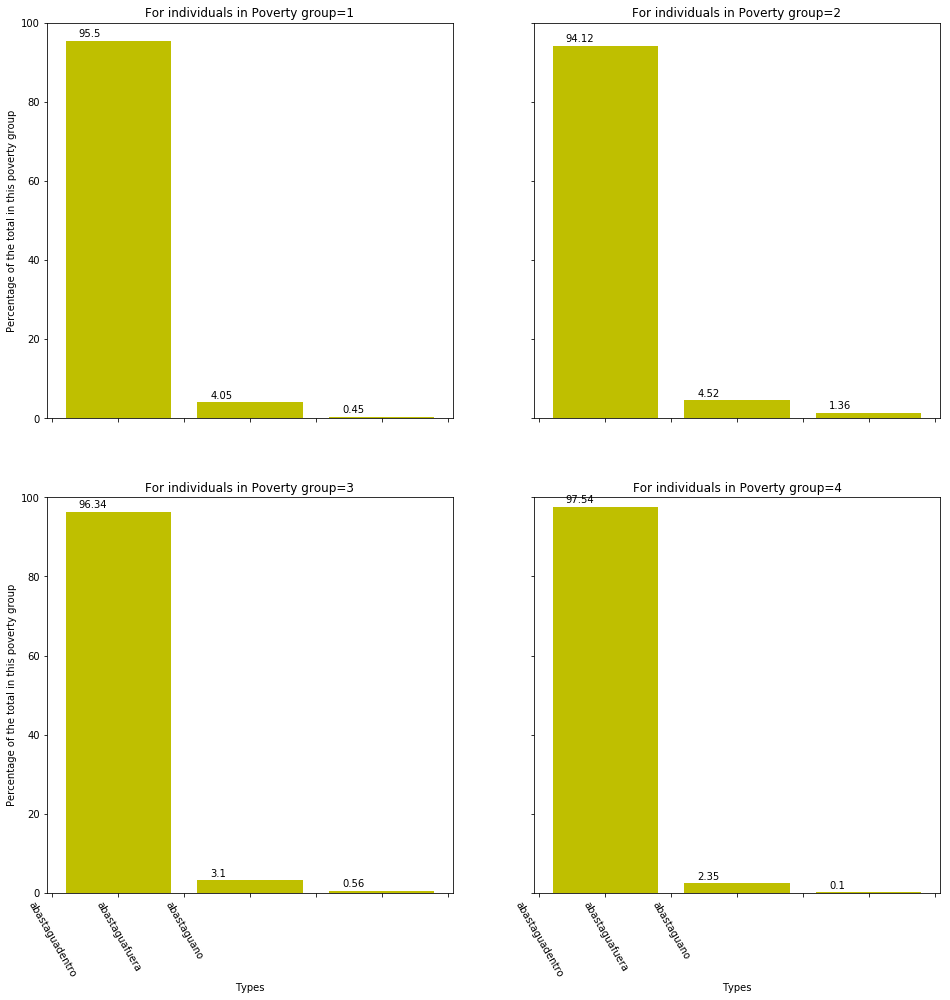

In [21]:
plot_dwelling_property(water_provision_df)

* Again, this distribution is also pretty much the same across all the groups. Almost all (~95%) of the people in all the groups enjoy water provision inside their dwellings.

**_We may conclude that these features are not representative of the poverty levels._**

### Electricity:

In [22]:
electricity_df = df_train_heads.groupby('Target').sum()[['public', 'planpri', 'noelec', 'coopele']]
electricity_df

public  planpri  noelec  coopele
Target                                  
1          196        0       2       23
2          385        1       4       50
3          310        0       0       45
4         1744        1       3      205

```
public, "=1 electricity from CNFL,  ICE,  ESPH/JASEC"
planpri, =1 electricity from private plant
noelec, =1 no electricity in the dwelling
coopele, =1 electricity from cooperative
```

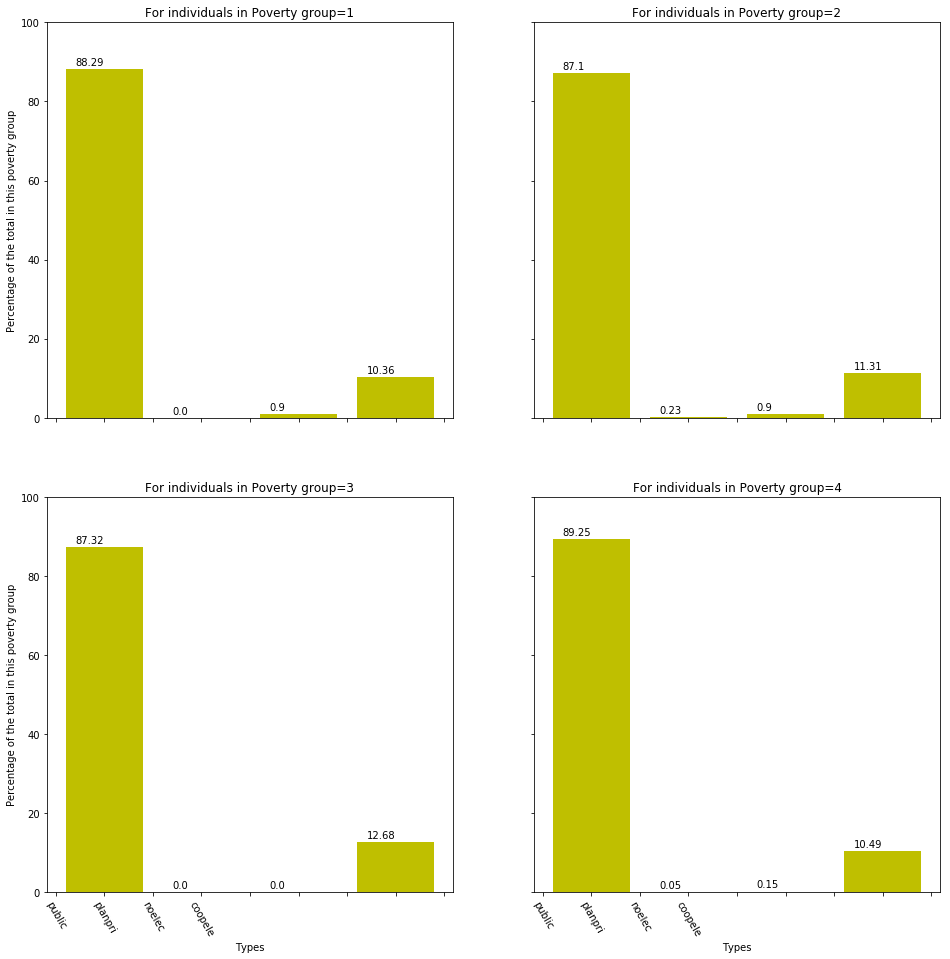

In [23]:
plot_dwelling_property(electricity_df)

* Again, this distribution is also pretty much the same across all the poverty groups. ~88% of the people in all the groups get electricity from `CNFL,  ICE,  ESPH/JASEC` and ~11% get it from cooperative.

**_We may conclude that these features are not representative of the poverty levels._**

### Main source of energy in cooking:

In [24]:
cooking_energy_df = df_train_heads.groupby('Target').sum()[['energcocinar1', 'energcocinar2', 'energcocinar3',
                                                      'energcocinar4']]
cooking_energy_df

energcocinar1  energcocinar2  energcocinar3  energcocinar4
Target                                                            
1                   4             76            116             26
2                   3            171            224             44
3                   3            158            171             23
4                   5           1095            809             45

```
energcocinar1, =1 no main source of energy used for cooking (no kitchen)
energcocinar2, =1 main source of energy used for cooking electricity
energcocinar3, =1 main source of energy used for cooking gas
energcocinar4, =1 main source of energy used for cooking wood charcoal
```

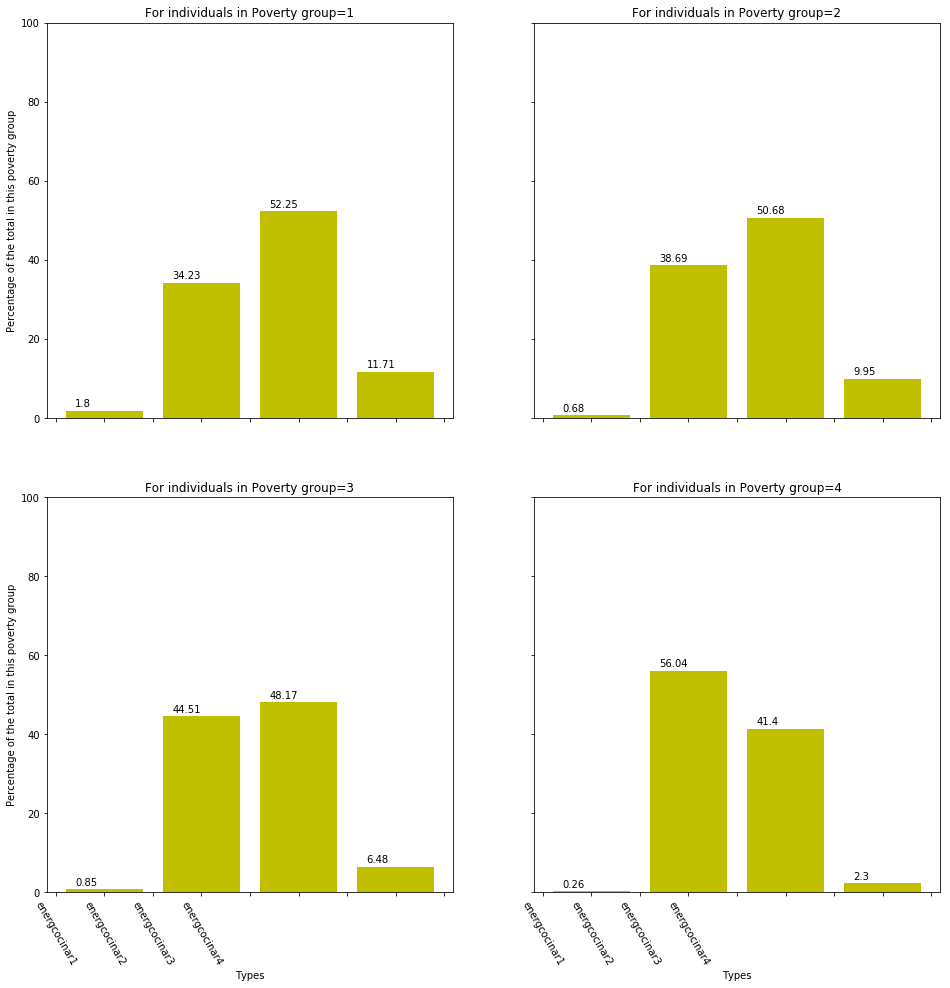

In [25]:
plot_dwelling_property(cooking_energy_df)

* Here, we see that gas and electricity are the major sources of energy in the kitchens for all the people.
* For the poverty group 4 (non-vulnerable), electricity is slightly more popular than gas whereas in the other groups, gas is the more popular choice.
* As we move from group 1 (extreme) to group 4 (non-vulnerable), the popularity of electricity increases and that of gas decreases. 

### Household size:

In [26]:
avg_household_size_df = df_train_heads.groupby('Target').mean()['hhsize']
avg_household_size_df

Target
1    3.486486
2    3.524887
3    3.383099
4    3.078813
Name: hhsize, dtype: float64

In [27]:
df_train.groupby('Target').mean().head()

v2a1    hacdor     rooms    hacapo      v14a    refrig  \
Target                                                                    
1        84806.464052  0.147020  4.327152  0.075497  0.988079  0.887417   
2        97015.166172  0.067627  4.483406  0.047589  0.986850  0.928616   
3       102618.093333  0.048801  4.729529  0.030604  0.991729  0.961952   
4       193589.258521  0.014343  5.205971  0.009340  0.998332  0.973316   

            v18q     v18q1      r4h1      r4h2      r4h3      r4m1      r4m2  \
Target                                                                         
1       0.079470  1.733333  0.796026  1.160265  1.956291  0.800000  1.701987   
2       0.078272  1.272000  0.560426  1.474640  2.035066  0.628053  1.707577   
3       0.118280  1.279720  0.405294  1.692308  2.097601  0.442514  1.740281   
4       0.314710  1.411765  0.283856  1.605070  1.888926  0.279019  1.628586   

            r4m3      r4t1      r4t2      r4t3    tamhog    tamviv  escolari  \
Target                                                                         
1       2.501987  1.596026  2.862252  4.458278  4.455629  4.570861  4.737748   
2       2.335629  1.188478  3.182217  4.370695  4.361929  4.529743  5.166562   
3       2.182796  0.847808  3.432589  4.280397  4.272953  4.421836  5.774194   
4       1.907605  0.562875  3.233656  3.796531  3.789693  3.852735  8.339560   

         rez_esc    hhsize  paredblolad  paredzocalo  paredpreb  pareddes  \
Target                                                                      
1       0.542553  4.455629     0.390728     0.107285   0.247682  0.015894   
2       0.597964  4.361929     0.381340     0.113338   0.245460  0.026299   
3       0.505882  4.272953     0.512821     0.097601   0.233251  0.009098   
4       0.356873  3.789693     0.692628     0.060540   0.156104  0.002835   

        paredmad  paredzinc  paredfibras  paredother  pisomoscer  pisocemento  \
Target                                                                          
1       0.203974   0.031788     0.002649    0.000000    0.466225     0.377483   
2       0.204759   0.021290     0.004383    0.003131    0.494051     0.351284   
3       0.143921   0.003309     0.000000    0.000000    0.610422     0.276261   
4       0.075050   0.010507     0.000834    0.001501    0.790861     0.158439   

        pisoother  pisonatur  pisonotiene  pisomadera  techozinc  \
Target                                                             
1        0.000000   0.001325     0.043709    0.111258   0.961589   
2        0.000000   0.005636     0.038823    0.110207   0.953663   
3        0.000000   0.000000     0.019024    0.094293   0.991729   
4        0.001501   0.000000     0.006504    0.042695   0.971147   

        techoentrepiso  techocane  techootro  cielorazo  abastaguadentro  \
Target                                                                     
1             0.015894   0.009272   0.000000   0.421192         0.956291   
2             0.016281   0.005009   0.000000   0.474014         0.936756   
3             0.004136   0.002481   0.000000   0.559140         0.953681   
4             0.021014   0.002001   0.003502   0.787692         0.975484   

        abastaguafuera  abastaguano    public   planpri    noelec   coopele  \
Target                                                                        
1             0.039735     0.003974  0.886093  0.000000  0.005298  0.103311   
2             0.048842     0.014402  0.876018  0.000626  0.005636  0.112085   
3             0.042184     0.004136  0.884202  0.000000  0.000000  0.115798   
4             0.024016     0.000500  0.887592  0.000334  0.001334  0.110407   

        sanitario1  sanitario2  sanitario3  sanitario5  sanitario6  \
Target                                                               
1         0.009272    0.160265    0.782781    0.046358    0.001325   
2         0.007514    0.174076    0.782718    0.029430    0.006262   
3         0.007444    0.129859   

### Urban or rural:

Let's try to understand the demographics of the urban and the rural population

In [28]:
urban_rural_df = df_train_heads.groupby('Target').sum()[['area1', 'area2']]
urban_rural_df['UrbanPercentage'] = urban_rural_df['area1'] * round((100/sum(urban_rural_df['area1'])), 6)
urban_rural_df['RuralPercentage'] = urban_rural_df['area2'] * round((100/sum(urban_rural_df['area2'])), 6)
urban_rural_df

area1  area2  UrbanPercentage  RuralPercentage
Target                                                
1         143     79         6.719856         9.349097
2         293    149        13.768656        17.633107
3         230    125        10.808160        14.792875
4        1462    492        68.702304        58.224756

```
area1, =1 zona urbana
area2, =1 zona rural
```

The following pattern is seen in both urban and rural areas:

* __~ 58-68%__ of the houses are in Target 4 (__non-vulnerable__)
* __~ 10-15%__ of the houses are in Target 2 (__moderate__)
* __~ 13-18%__ of the houses are in Target 3 (__vulnerable__)
* __~ 6-10%__ of the houses are in Target 1 (__extreme__)

### Region:

In [29]:
region_df = df_train_heads.groupby('Target').sum()[['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']]
region_df

lugar1  lugar2  lugar3  lugar4  lugar5  lugar6
Target                                                
1           91      23      24      30      32      22
2          206      44      41      51      54      46
3          188      32      34      34      40      27
4         1272     170      97     131     149     135

```
lugar1, =1 region Central
lugar2, =1 region Chorotega
lugar3, =1 region PacÃƒÂ­fico central
lugar4, =1 region Brunca
lugar5, =1 region Huetar AtlÃƒÂ¡ntica
lugar6, =1 region Huetar Norte
```

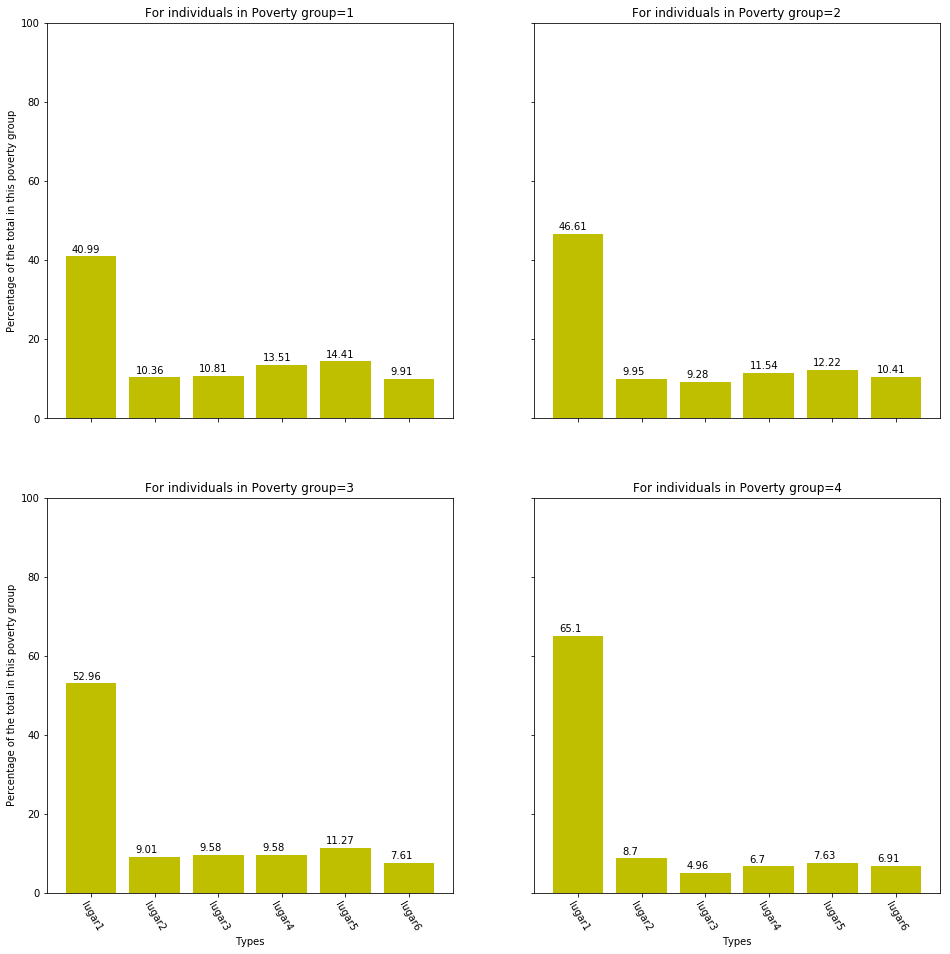

In [30]:
plot_dwelling_property(region_df)

In [31]:
region_df.T

Target   1    2    3     4
lugar1  91  206  188  1272
lugar2  23   44   32   170
lugar3  24   41   34    97
lugar4  30   51   34   131
lugar5  32   54   40   149
lugar6  22   46   27   135

* `Central` region has the maximum population
* A major portion (65%) of the poverty group 4 (non-vulnerable) people live in `Central` region
* Exactly 0 people live in lugar5 (`Huetar AtlÃƒÂ¡ntica`) and lugar6(`Huetar Norte`)


### Conclusion:-

These features do not convey any useful information about the `Target` variable:
* 'sanitario1', 'sanitario6'
* 'elimbasu4', 'elimbasu5', 'elimbasu6'
* 'techozinc', 'techoentrepiso', 'techocane', 'techootro'
* 'abastaguadentro', 'abastaguafuera', 'abastaguano'
* 'public', 'planpri', 'noelec', 'coopele'
* 'lugar5', 'lugar6'

Removing them increased my F1-score by 1.5%.

In [32]:
all_data.drop(columns=['sanitario1', 'sanitario6',
                       'elimbasu4', 'elimbasu5', 'elimbasu6',
                       'techozinc', 'techoentrepiso', 'techocane', 'techootro',
                       'abastaguadentro', 'abastaguafuera', 'abastaguano',
                       'public', 'planpri', 'noelec', 'coopele',
                       'lugar5', 'lugar6'], inplace=True)

## Monthly rent - 

A large percentage of `v2a1` (the monthly rent column) is empty. We will analyse the 

## Education -

### escolari:

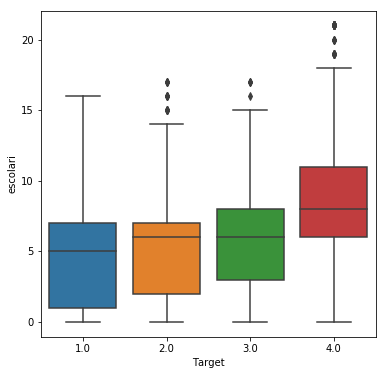

In [33]:
sns.boxplot(x='Target', y='escolari', data=all_data.loc[:ntrain]);

Okay, so education affects the poverty label to some extent. Or, maybe poverty label affects one's ability to get education.

## Numerical or Categorical?

Number of numerical features:  120
Number of categorical features:  4


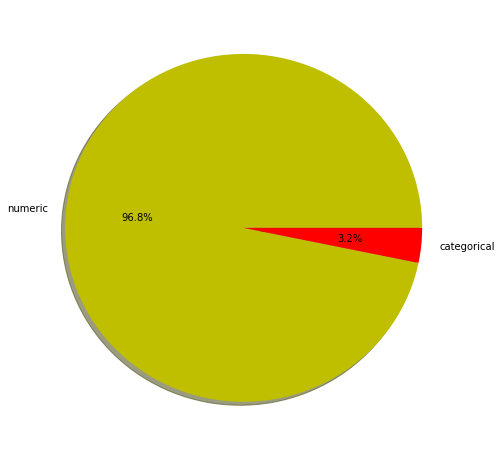

In [34]:
num_features = all_data._get_numeric_data().columns
num_features_length = len(num_features)

categ_features = pd.Index(list(set(all_data.columns) - set(num_features)))
categ_features_length = len(categ_features)

print("Number of numerical features: ", num_features_length)
print("Number of categorical features: ", categ_features_length)

labels = ['numeric', 'categorical']
colors = ['y', 'r']
plt.figure(figsize=(8, 8))
plt.pie([num_features_length, categ_features_length], 
        labels=labels, 
        autopct='%1.1f%%', 
        shadow=True, 
        colors=colors);

Let's have a look at the categorical features:

In [35]:
all_data[categ_features].head()

idhogar edjefe edjefa dependency
0  21eb7fcc1     10     no         no
1  0e5d7a658     12     no          8
2  2c7317ea8     no     11          8
3  2b58d945f     11     no        yes
4  2b58d945f     11     no        yes

Its no surprise that `idhogar` is categorical but according to the [data description provided with the challenge](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data), the other 3 features should take numerical values. Instead they contain lots of 'yes' and 'no' values as well. 

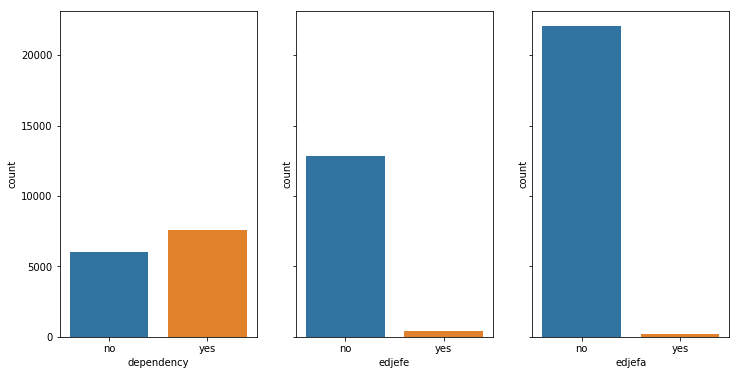

In [36]:
_, axarr = plt.subplots(nrows=1, ncols=3, sharey='row', figsize=(12, 6))

for idx, feature in enumerate(['dependency', 'edjefe', 'edjefa']):
    sns.countplot(x=feature, data=all_data[all_data[feature].isin(['yes', 'no'])], ax=axarr[idx])

A look at [this discussion](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/discussion/61403#359554) showed that there is a glitch with `dependency`, `edjefe` and `edjefa`. In all of these cases,, 'yes' implies 1 and 'no' implies 0. So, let's fix that..

In [37]:
yes_no_map = {'no': 0, 'yes': 1}
    
all_data['dependency'] = all_data['dependency'].replace(yes_no_map).astype(np.float32)
all_data['edjefe'] = all_data['edjefe'].replace(yes_no_map).astype(np.float32)
all_data['edjefa'] = all_data['edjefa'].replace(yes_no_map).astype(np.float32)

Now, all the features are numeric.

### Numerical features that are binary:

In [38]:
num_binary_features = []

for feature in all_data.columns:
    if sorted(df_train[feature].unique()) in [[0, 1], [0], [1]]:
        num_binary_features.append(feature)
        
print("Total number of binary-numerical features: ", len(num_binary_features))
print("Binary-numerical features: ")
num_binary_features

Total number of binary-numerical features:  84
Binary-numerical features: 


['area1',
 'area2',
 'cielorazo',
 'computer',
 'dis',
 'elimbasu1',
 'elimbasu2',
 'elimbasu3',
 'energcocinar1',
 'energcocinar2',
 'energcocinar3',
 'energcocinar4',
 'epared1',
 'epared2',
 'epared3',
 'estadocivil1',
 'estadocivil2',
 'estadocivil3',
 'estadocivil4',
 'estadocivil5',
 'estadocivil6',
 'estadocivil7',
 'etecho1',
 'etecho2',
 'etecho3',
 'eviv1',
 'eviv2',
 'eviv3',
 'female',
 'hacapo',
 'hacdor',
 'instlevel1',
 'instlevel2',
 'instlevel3',
 'instlevel4',
 'instlevel5',
 'instlevel6',
 'instlevel7',
 'instlevel8',
 'instlevel9',
 'lugar1',
 'lugar2',
 'lugar3',
 'lugar4',
 'male',
 'mobilephone',
 'paredblolad',
 'pareddes',
 'paredfibras',
 'paredmad',
 'paredother',
 'paredpreb',
 'paredzinc',
 'paredzocalo',
 'parentesco1',
 'parentesco10',
 'parentesco11',
 'parentesco12',
 'parentesco2',
 'parentesco3',
 'parentesco4',
 'parentesco5',
 'parentesco6',
 'parentesco7',
 'parentesco8',
 'parentesco9',
 'pisocemento',
 'pisomadera',
 'pisomoscer',
 'pisonatur',
 

### Non-binary features:

Total number of non-binary-numerical features:  40
Non-binary numerical features: 


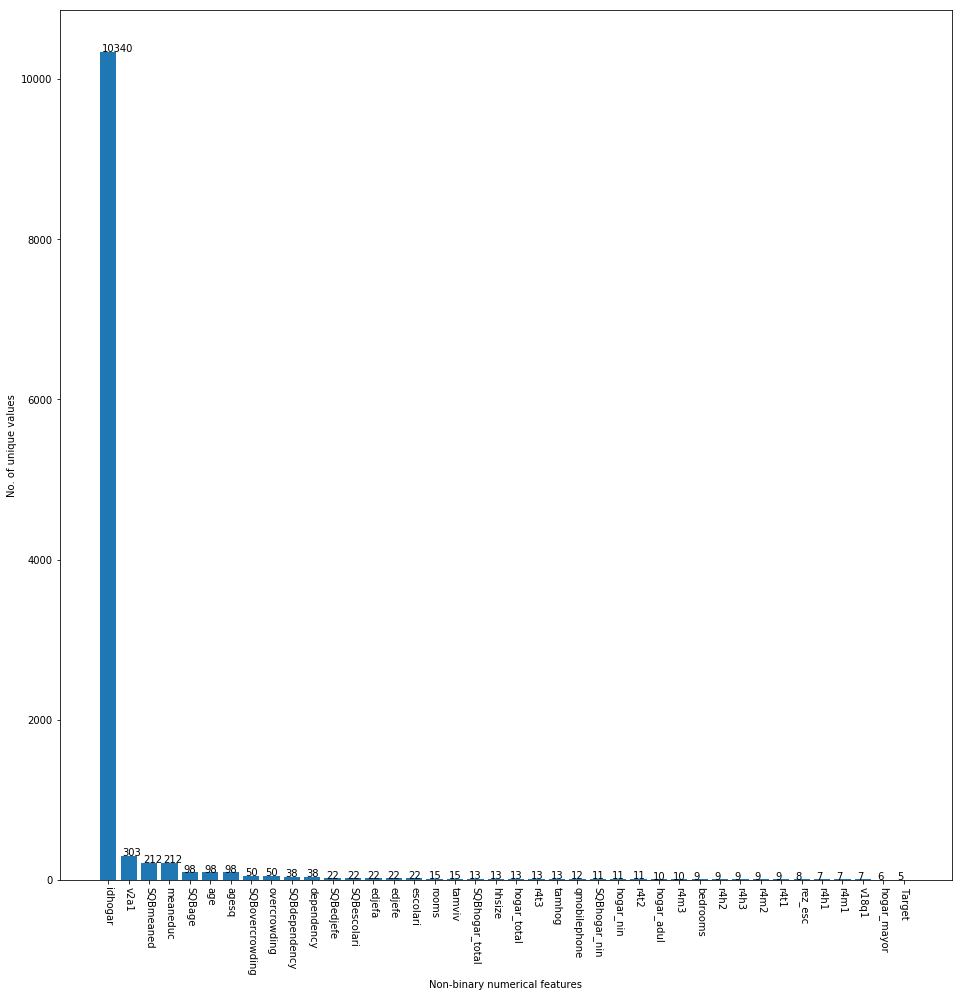

In [39]:
num_non_binary_features = [feature for feature in all_data.columns if feature not in num_binary_features]

print("Total number of non-binary-numerical features: ", len(num_non_binary_features))
print("Non-binary numerical features: ")

num_non_binary_features_dict = {feature: len(all_data[feature].unique()) for feature in num_non_binary_features}

num_non_binary_features_sorted = sorted(num_non_binary_features_dict, 
                                        key=lambda feature: num_non_binary_features_dict[feature], 
                                        reverse=True)

num_non_binary_features_len_sorted = [num_non_binary_features_dict[feature] for feature in num_non_binary_features_sorted]

plt.figure(figsize=(16, 16))
barplot_with_anotate(num_non_binary_features_sorted, num_non_binary_features_len_sorted);
plt.ylabel("No. of unique values");
plt.xlabel("Non-binary numerical features");

Out of these 39 features, the following are continuous in nature:
* v2al
* meaneduc
* SQBmeaned
* dependency
* SQBdependency


All the other features are discrete in nature.

## Summary

### Binary features:

In [40]:
all_data[num_binary_features].describe()

area1         area2     cielorazo      computer           dis  \
count  33413.000000  33413.000000  33413.000000  33413.000000  33413.000000   
mean       0.719630      0.280370      0.671804      0.110646      0.056984   
std        0.449187      0.449187      0.469563      0.313697      0.231815   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        1.000000      0.000000      1.000000      0.000000      0.000000   
75%        1.000000      1.000000      1.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

          elimbasu1     elimbasu2     elimbasu3  energcocinar1  energcocinar2  \
count  33413.000000  33413.000000  33413.000000   33413.000000   33413.000000   
mean       0.877503      0.033370      0.085625       0.002125       0.480502   
std        0.327864      0.179604      0.279814       0.046049       0.499627   
min        0.000000      0.000000      0.000000       0.000000       0.000000   
25%        1.000000      0.000000      0.000000       0.000000       0.000000   
50%        1.000000      0.000000      0.000000       0.000000       0.000000   
75%        1.000000      0.000000      0.000000       0.000000       1.000000   
max        1.000000      1.000000      1.000000       1.000000       1.000000   

       energcocinar3  energcocinar4       epared1       epared2       epared3  \
count   33413.000000   33413.000000  33413.000000  33413.000000  33413.000000   
mean        0.471613       0.045761      0.108880      0.324215      0.566905   
std         0.499201       0.208969      0.311493      0.468088      0.495511   
min         0.000000       0.000000      0.000000      0.000000      0.000000   
25%         0.000000       0.000000      0.000000      0.000000      0.000000   
50%         0.000000       0.000000      0.000000      0.000000      1.000000   
75%         1.000000       0.000000      0.000000      1.000000      1.000000   
max         1.000000       1.000000      1.000000      1.000000      1.000000   

       estadocivil1  estadocivil2  estadocivil3  estadocivil4  estadocivil5  \
count  33413.000000  33413.000000   33413.00000  33413.000000  33413.000000   
mean       0.137821      0.123216       0.27187      0.034777      0.059947   
std        0.344717      0.328689       0.44493      0.183217      0.237392   
min        0.000000      0.000000       0.00000      0.000000      0.000000   
25%        0.000000      0.000000       0.00000      0.000000      0.000000   
50%        0.000000      0.000000       0.00000      0.000000      0.000000   
75%        0.000000      0.000000       1.00000      0.000000      0.000000   
max        1.000000      1.000000       1.00000      1.000000      1.000000   

       estadocivil6  estadocivil7       etecho1       etecho2       etecho3  \
count  33413.000000  33413.000000  33413.000000  33413.000000  33413.000000   
mean       0.033340      0.339030      0.127555      0.302008      0.570437   
std        0.179526      0.473387      0.333599      0.459136      0.495021   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      1.000000   
75%        0.000000      1.000000      0.000000      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

              eviv1         eviv2         eviv3        female        hacapo  \
count  33413.000000  33413.000000  33413.000000  33413.000000  33413.000000   
mean       0.102086      0.265466      0.632448      0.511597      0.027055   
std        0.302766      0.441587      0.482146      0.499873      0.162247   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000    

### Non-binary continuous features:

In [41]:
num_conti_features = pd.Index(['v2a1', 'meaneduc', 'dependency', 'SQBmeaned', 'SQBdependency'])
all_data[num_conti_features].describe()

v2a1      meaneduc    dependency     SQBmeaned  SQBdependency
count  9.150000e+03  33377.000000  33413.000000  33377.000000   33413.000000
mean   1.720308e+05      9.178666      1.172238    101.104384       4.094081
std    1.550035e+05      4.105725      1.649249     90.467735      12.939225
min    0.000000e+00      0.000000      0.000000      0.000000       0.000000
25%    8.000000e+04      6.000000      0.333333     36.000000       0.111111
50%    1.350000e+05      8.666667      0.666667     75.111115       0.444444
75%    2.000000e+05     11.500000      1.333333    132.250000       1.777778
max    2.852700e+06     37.000000      8.000000   1369.000000      64.000000

### Non-binary discrete features:

In [42]:
num_discrete_features = pd.Index([feature for feature in num_non_binary_features if feature not in num_conti_features])
all_data[num_discrete_features].describe()

SQBage     SQBedjefe   SQBescolari  SQBhogar_nin  SQBhogar_total  \
count  33413.000000  33413.000000  33413.000000  33413.000000    33413.000000   
mean    1653.786909     53.919343     74.384820      3.873851       19.118966   
std     1750.049285     77.637447     76.933222      6.898213       17.737165   
min        0.000000      0.000000      0.000000      0.000000        1.000000   
25%      289.000000      0.000000     16.000000      0.000000        9.000000   
50%     1024.000000     36.000000     36.000000      1.000000       16.000000   
75%     2601.000000     81.000000    121.000000      4.000000       25.000000   
max     9409.000000    441.000000    441.000000    100.000000      169.000000   

       SQBovercrowding       Target           age         agesq      bedrooms  \
count     33413.000000  9557.000000  33413.000000  33413.000000  33413.000000   
mean          3.474577     3.302292     34.411097   1653.786909      2.745069   
std           6.053864     1.009565     21.672040   1750.049285      0.962491   
min           0.020408     1.000000      0.000000      0.000000      1.000000   
25%           1.000000     3.000000     17.000000    289.000000      2.000000   
50%           2.250000     4.000000     32.000000   1024.000000      3.000000   
75%           4.000000     4.000000     51.000000   2601.000000      3.000000   
max         169.000000     4.000000     97.000000   9409.000000      9.000000   

             edjefa        edjefe      escolari        hhsize    hogar_adul  \
count  33413.000000  33413.000000  33413.000000  33413.000000  33413.000000   
mean       2.827821      5.170353      7.210726      4.015264      2.604405   
std        4.606153      5.214174      4.731904      1.731102      1.149267   
min        0.000000      0.000000      0.000000      1.000000      0.000000   
25%        0.000000      0.000000      4.000000      3.000000      2.000000   
50%        0.000000      6.000000      6.000000      4.000000      2.000000   
75%        6.000000      9.000000     11.000000      5.000000      3.000000   
max       21.000000     21.000000     21.000000     13.000000      9.000000   

        hogar_mayor     hogar_nin   hogar_total  overcrowding  qmobilephone  \
count  33413.000000  33413.000000  33413.000000  33413.000000  33413.000000   
mean       0.291982      1.410858      4.015264      1.631687      2.835363   
std        0.603112      1.372366      1.731102      0.901221      1.455610   
min        0.000000      0.000000      1.000000      0.142857      0.000000   
25%        0.000000      0.000000      3.000000      1.000000      2.000000   
50%        0.000000      1.000000      4.000000      1.500000      3.000000   
75%        0.000000      2.000000      5.000000      2.000000      4.000000   
max        5.000000     10.000000     13.000000     13.000000     11.000000   

               r4h1          r4h2          r4h3          r4m1          r4m2  \
count  33413.000000  33413.000000  33413.000000  33413.000000  33413.000000   
mean       0.407775      1.562595      1.970371      0.392033      1.658007   
std        0.704245      1.003650      1.176670      0.681584      0.908528   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      1.000000      1.000000      0.000000      1.000000   
50%        0.000000      1.000000      2.000000      0.000000      1.000000   
75%        1.000000      2.000000      3.000000      1.000000      2.000000   
max        6.000000      8.000000      8.000000      6.000000      8.000000   

               r4m3          r4t1          r4t2          r4t3      rez_esc  \
count  33413.000000  33413.000000  33413.000000  33413.000000  5832.000000   
mean       2.050040      0.799808      3.220603      4.020411     0.434842   
std        1.180957      1.062485      1.376299      1.730911     1.581884   
min        0.000000      0.000000      1.000000      1.000000     0.000000   
25%        1.000000      0.

# Preprocessing

## 1. Missing values imputation:

In [43]:
def missing_features(data, column_set):
    incomplete_features = {feature: data.shape[0]-sum(data[feature].value_counts())
                                   for feature in column_set
                                   if not sum(data[feature].value_counts()) == data.shape[0]}
    incomplete_features_sorted = sorted(incomplete_features, key=lambda feature: incomplete_features[feature], reverse=True)
    incompleteness = [round((incomplete_features[feature]/data.shape[0])*100, 2) for feature in incomplete_features_sorted]
    plt.figure(figsize=(12, 6))
    barplot_with_anotate(incomplete_features_sorted, incompleteness)
    plt.ylabel("Percentage (%) of values that are missing")
    #plt.rcParams["figure.figsize"] = [12, 6]
    
    for feature, percentage in zip(incomplete_features_sorted, incompleteness):
        print("Feature:", feature)
        print("No. of NaNs:", incomplete_features[feature], "(", percentage, ")")

Feature: rez_esc
No. of NaNs: 27581 ( 82.55 )
Feature: v18q1
No. of NaNs: 25468 ( 76.22 )
Feature: v2a1
No. of NaNs: 24263 ( 72.62 )
Feature: Target
No. of NaNs: 23856 ( 71.4 )
Feature: SQBmeaned
No. of NaNs: 36 ( 0.11 )
Feature: meaneduc
No. of NaNs: 36 ( 0.11 )


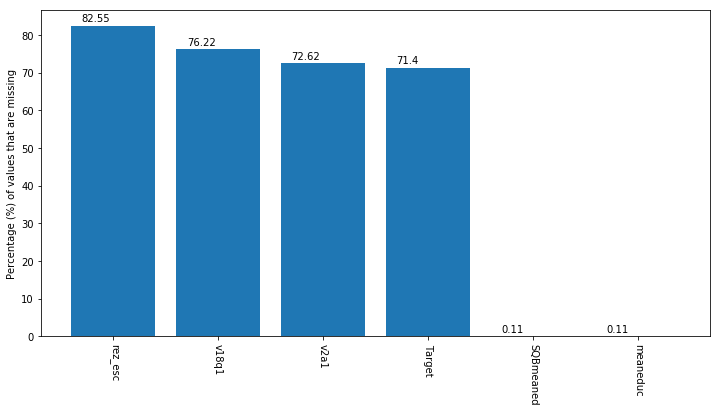

In [44]:
missing_features(all_data, all_data.columns)

* [This discussion](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/discussion/61403#360609) shows how missing values of `v2a1` and `v18q1` should be handled.

* `rez_esc` (Years behind in school): NaN implies that the person does not remember. Considering that along with the large percentage of NaN values, we are better off dropping that column.


* `meaneduc` and `SQBmeaned`: With the average of the columns.

#### `v2a1` :-

In [45]:
# entries which have both v2a1 as NaN and tipovivi3 as 0
all_data[['v2a1', 'tipovivi3']][all_data['tipovivi3'] == 0][all_data['v2a1'].isnull()].shape

(24263, 2)

We see that all those entries where `v2a1` is Nan also have `tipovivi3` as 0, which implies that all those houses are not rented. 

Hence, we should fill the missing values of `v2a1` with 0.

In [46]:
# handling v2a1
all_data.loc[:, 'v2a1'].fillna(0, inplace=True)

#### `v18q1` :-

In [47]:
# entries which have v18q as 0 and v18q1 as NaN
all_data[['v18q1', 'v18q']][all_data['v18q'] == 0][all_data['v18q1'].isnull()].shape

(25468, 2)

We see that `v18q1` is `NaN` only for those entries which have `v18q` == 0. Thus, `v18q1` is missing only when the house does not have a tablet. 

Hence, we should fill the missing values of `v18q1` with 0.

In [48]:
# handling v18q1
all_data.loc[:, 'v18q1'].fillna(0, inplace=True)

#### `meaneduc` and `SQBmeaned` :-

In [49]:
# handling meaneduc and SQBmeaned
all_data.loc[:, 'meaneduc'].fillna(all_data['meaneduc'].mean(), inplace=True)
all_data.loc[:, 'SQBmeaned'].fillna(all_data['SQBmeaned'].mean(), inplace=True)

#### `rez_esc` :-

Drop it.

In [50]:
all_data.drop(columns=['rez_esc'], inplace=True)

## 2. Convert dummy to ordinal:

These features have order in their meaning:
```
epared1, =1 if walls are bad
epared2, =1 if walls are regular
epared3, =1 if walls are good
etecho1, =1 if roof are bad
etecho2, =1 if roof are regular
etecho3, =1 if roof are good
eviv1, =1 if floor are bad
eviv2, =1 if floor are regular
eviv3, =1 if floor are good
instlevel1, =1 no level of education
instlevel2, =1 incomplete primary
instlevel3, =1 complete primary
instlevel4, =1 incomplete academic secondary level
instlevel5, =1 complete academic secondary level
instlevel6, =1 incomplete technical secondary level
instlevel7, =1 complete technical secondary level
instlevel8, =1 undergraduate and higher education
instlevel9, =1 postgraduate higher education
```
We should use them as ordinal features.

In [51]:
all_data['WallQual'] = all_data['epared1'] + 2*all_data['epared2'] + 3*all_data['epared3']

all_data['RoofQual'] = all_data['etecho1'] + 2*all_data['etecho2'] + 3*all_data['etecho3']

all_data['FloorQual'] = all_data['eviv1'] + 2*all_data['eviv2'] + 3*all_data['eviv3']

all_data['EducationLevel'] = all_data['instlevel1'] + 2*all_data['instlevel2'] + 3*all_data['instlevel3'] + \
    4*all_data['instlevel4'] + 5*all_data['instlevel5'] + 6*all_data['instlevel6'] + 7*all_data['instlevel7'] + \
    8*all_data['instlevel8'] + 9*all_data['instlevel9']

In [52]:
all_data.drop(columns=['epared1', 'epared2', 'epared3',
                       'etecho1', 'etecho2', 'etecho3',
                       'eviv1', 'eviv2', 'eviv3',
                       'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5',
                       'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9'], inplace=True)

## 3. Remove redundant features:

I have used [this kernel](https://www.kaggle.com/kuriyaman1002/reduce-features-140-84-keeping-f1-score) to identify some of these features -

* The following can be generated from linear combination of r4h* and r4m*:
    ```
    r4t1, persons younger than 12 years of age
    r4t2, persons 12 years of age and older
    r4t3, Total persons in the household
    ```

* The following mean the same as `hogar_total`:
    ```
    tamhog, size of the household
    tamviv, number of persons living in the household
    hhsize, household size
    r4t3, Total persons in the household
    ```


* `v18q` can be generated by v18q1
* `mobilephone` can be generated by qmobilephone

In [53]:
redundant_features = ['r4t1', 'r4t2', 'r4t3', 'tamhog', 'tamviv', 'hhsize', 'r4t3', 'v18q', 'mobilephone']
all_data.drop(columns=redundant_features, inplace=True)

## 4. Create new household-wide features:

1. Hand-engineered features:

    * Monthly rent per room - `v2a1/rooms`
    * Monthly rent per adult - `v2a1/hogar_adul`
    * No. of adults per room - `hogar_adul/rooms`
    * No. of adults per bedroom - `hogar_adul/bedrooms`
    
2. Average of individual-level features per household

3. Minimum of individual-level features per household

4. Maximum of individual-level features per household

5. Sum of individual-level features per household

6. Standard deviation of individual-level features per household


I have taken help from [this excellent analysis](https://www.kaggle.com/willkoehrsen/start-here-a-complete-walkthrough) done by Will Koehrsen.

In [54]:
all_data['RentPerRoom'] = all_data['v2a1'] / all_data['rooms']

all_data['AdultsPerRoom'] = all_data['hogar_adul'] / all_data['rooms']

all_data['AdultsPerBedroom'] = all_data['hogar_adul'] / all_data['bedrooms']

In [55]:
# individual level boolean features
ind_bool = ['dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'EducationLevel']

# individual level ordered features
ind_ordered = ['escolari', 'age']

In [56]:
f = lambda x: x.std(ddof=0)
f.__name__ = 'std_0'
ind_agg = all_data.groupby('idhogar')[ind_ordered + ind_bool].agg(['mean', 'max', 'min', 'sum', f])

new_cols = []
for col in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')

ind_agg.columns = new_cols
ind_agg.head()

escolari-mean  escolari-max  escolari-min  escolari-sum  \
idhogar                                                              
000a08204       8.666667            14             0            26   
000bce7c4       2.500000             5             0             5   
001845fb0      10.250000            14             6            41   
001ff74ca       8.000000            16             0            16   
003123ec2       3.250000             7             0            13   

           escolari-std_0   age-mean  age-max  age-min  age-sum  age-std_0  \
idhogar                                                                      
000a08204        6.182412  20.666667       30        4       62  11.813363   
000bce7c4        2.500000  61.500000       63       60      123   1.500000   
001845fb0        2.861381  35.500000       52       19      142  14.221463   
001ff74ca        8.000000  19.000000       38        0       38  19.000000   
003123ec2        3.269174  12.750000       24        1       51  10.779031   

           dis-mean  dis-max  dis-min  dis-sum  dis-std_0  male-mean  \
idhogar                                                                
000a08204       0.0        0        0        0        0.0   0.666667   
000bce7c4       0.5        1        0        1        0.5   0.500000   
001845fb0       0.0        0        0        0        0.0   0.500000   
001ff74ca       0.0        0        0        0        0.0   0.000000   
003123ec2       0.0        0        0        0        0.0   0.750000   

           male-max  male-min  male-sum  male-std_0  female-mean  female-max  \
idhogar                                                                        
000a08204         1         0         2    0.471405     0.333333           1   
000bce7c4         1         0         1    0.500000     0.500000           1   
001845fb0         1         0         2    0.500000     0.500000           1   
001ff74ca         0         0         0    0.000000     1.000000           1   
003123ec2         1         0         3    0.433013     0.250000           1   

           female-min  female-sum  female-std_0  estadocivil1-mean  \
idhogar                                                              
000a08204           0           1      0.471405           0.333333   
000bce7c4           0           1      0.500000           0.000000   
001845fb0           0           2      0.500000           0.000000   
001ff74ca           1           2      0.000000           0.500000   
003123ec2           0           1      0.433013           0.500000   

           estadocivil1-max  estadocivil1-min  estadocivil1-sum  \
idhogar                                                           
000a08204                 1                 0                 1   
000bce7c4                 0                 0                 0   
001845fb0                 0                 0                 0   
001ff74ca                 1                 0                 1   
003123ec2                 1                 0                 2   

           estadocivil1-std_0  estadocivil2-mean  estadocivil2-max  \
idhogar                                                              
000a08204            0.471405           0.666667                 1   
000bce7c4            0.000000           0.000000                 0   
001845fb0            0.000000           0.500000                 1   
001ff74ca            0.500000           0.000000                 0   
003123ec2            0.500000           0.500000                 1   

           estadocivil2-min  estadocivil2-sum  estadocivil2-std_0  \
idhogar                                                             
000a08204                 0                 2            0.471405   
000bce7c4                 0                 0            0.000000   
001845fb0                 0                 2            0.500000   
001ff74ca                 0                 0            0.000000   
003123ec2                 0              

In [57]:
print("Original number of features:", all_data.shape[1])

all_data = all_data.merge(ind_agg, on = 'idhogar', how = 'left')

print("Number of features after merging transformed individual level features", all_data.shape[1])

all_data.drop(columns=ind_bool+ind_ordered, inplace=True)

print("Number of features after dropping the individual level features", all_data.shape[1])

Original number of features: 104
Number of features after merging transformed individual level features 229
Number of features after dropping the individual level features 204


# Modelling

In [58]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [59]:
# drop the idhogar column
all_data.drop(columns=['idhogar'], inplace=True)

In [60]:
df_train = all_data[:ntrain][:]
df_test = all_data[ntrain:][:]
df_test = df_test.drop('Target', axis=1)

In [61]:
print(df_train.shape)
print(df_test.shape)

(9557, 203)
(23856, 202)


In [62]:
X_train= df_train.drop('Target', axis= 1)
Y_train= df_train['Target']

X_test= df_test

In [63]:
validation_scores = {}

In [64]:
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

I am going to try Random Forest and 2 gradient boosting machines - LightGBM and XGBoost.

I am going to use 10-fold cross-validation to get a CV score on each model for comparision.

### Random Forest:

In [65]:
random_forest = RandomForestClassifier()

validation_scores['Random Forest'] = cross_val_score(random_forest, X_train, Y_train, cv=10, scoring=scorer).mean()
print(validation_scores['Random Forest'])

0.3758600058627064


### LightGBM:

In [66]:
lightgbm = lgb.LGBMClassifier(class_weight='balanced')

validation_scores['LightGBM'] = cross_val_score(lightgbm, X_train, Y_train, cv=10, scoring=scorer).mean()
print(validation_scores['LightGBM'])

/home/nityeshaga/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/nityeshaga/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/nityeshaga/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/nityeshaga/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py

0.3622681151197868


/home/nityeshaga/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### XGBoost:

In [67]:
xgboost = xgb.XGBClassifier()

validation_scores['XGBoost'] = cross_val_score(xgboost, X_train, Y_train, cv=10, scoring=scorer).mean()
print(validation_scores['XGBoost']);

/home/nityeshaga/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/nityeshaga/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/nityeshaga/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/nityeshaga/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py

0.34415220415147896


/home/nityeshaga/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Comparing the various scores:

In [68]:
models_with_scores = pd.DataFrame({
    'Model': list(validation_scores.keys()),
    'Validation Score': list(validation_scores.values())})

models_with_scores.sort_values(by='Validation Score', ascending=False)

Model  Validation Score
0  Random Forest          0.375860
1       LightGBM          0.362268
2        XGBoost          0.344152

## Submission Models

### Random Forest:

In [69]:
submission_model_rf = RandomForestClassifier()
submission_model_rf.fit(X_train, Y_train);
final_pred_rf = submission_model_rf.predict(X_test)
final_pred_rf = final_pred_rf.astype(int)

In [70]:
submission_rf = pd.DataFrame({'Id': test_id,
                              'Target': final_pred_rf})
submission_rf.to_csv('submissionRF.csv', index=False)

### LightGBM:

In [71]:
submission_model_lgb = lgb.LGBMClassifier(class_weight='balanced')
submission_model_lgb.fit(X_train, Y_train);
final_pred_lgb = submission_model_lgb.predict(X_test)
final_pred_lgb = final_pred_lgb.astype(int)

/home/nityeshaga/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [72]:
submission_lgb = pd.DataFrame({'Id': test_id,
                           'Target': final_pred_lgb})
submission_lgb.to_csv('submissionLGB.csv', index=False)

### XGBoost:

In [73]:
submission_model_xgboost = lgb.LGBMClassifier()
submission_model_xgboost.fit(X_train, Y_train);
final_pred_xgb = submission_model_xgboost.predict(X_test)
final_pred_xgb = final_pred_xgb.astype(int)

/home/nityeshaga/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [74]:
submission_xgb = pd.DataFrame({'Id': test_id,
                           'Target': final_pred_xgb})
submission_xgb.to_csv('submissionXGB.csv', index=False)

### LightGBM + XGBoost stacked:

In [75]:
final_pred_stacked = ((final_pred_lgb + final_pred_xgb) / 2).astype(int)
submission_stacked = pd.DataFrame({'Id': test_id,
                           'Target': final_pred_stacked})
submission_stacked.to_csv('submissionStacked.csv', index=False)